In [64]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler,normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns 

In [65]:
# Importing Data

Retail_DS = pd.read_excel(r'Online Retail.xlsx')

<AxesSubplot:>

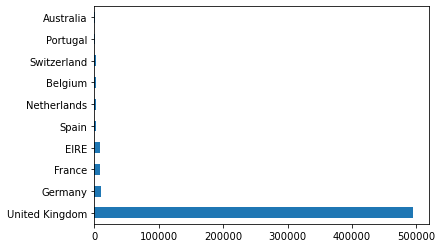

In [66]:
# Data Exploration - Grouping Country wise
import matplotlib.pyplot as plt 
CountryList = Retail_DS.Country.unique()
customer_country = Retail_DS[['Country','CustomerID']].drop_duplicates()
Retail_DS.Country.value_counts()[:10].plot(kind='barh')

In [67]:
#Data Cleaning - Removing Rows with negative values for Quantity
print("Total No.of Rows", Retail_DS.shape)
display(Retail_DS.describe())
Retail_DS = Retail_DS[(Retail_DS['Quantity']>0)]
print("No.of Rows after removing junk quantity values", Retail_DS.shape)
display(Retail_DS.describe())



Total No.of Rows (541909, 8)


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


No.of Rows after removing junk quantity values (531285, 8)


,Quantity,UnitPrice,CustomerID
count,531285.000000,531285.000000,397924.000000
mean,10.655262,3.857296,15294.315171
std,156.830323,41.810047,1713.169877
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [68]:
#Checking for Duplicate values 
Retail_DS['InvoiceDate'] = pd.to_datetime(Retail_DS['InvoiceDate'])
Duplicate_Rows = Retail_DS[Retail_DS.duplicated()]
#print(Duplicate_Rows.Head(10))
print("No.of Duplicate rows : ", Retail_DS.duplicated().sum())
#Checking for Missing values 
print("Feature ", "\t Missing values")
print(Retail_DS.isnull().sum())
#Dropping Missing Values 
Retail_DS = Retail_DS.dropna()
print("After Dropping Missing Values \n")
print("Feature","\t Missing values")
print(Retail_DS.isnull().sum())

No.of Duplicate rows :  5231
Feature  	 Missing values
InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133361
Country             0
dtype: int64
After Dropping Missing Values 

Feature 	 Missing values
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [69]:
# Calculating Total price and adding as new feature
Retail_DS['TotalPrice'] = Retail_DS['Quantity'] * Retail_DS['UnitPrice']
display(Retail_DS.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [70]:
# Calculating Snapshot date using recent invoice date 
from datetime import timedelta
Snapshot_Date = (Retail_DS['InvoiceDate'].max())+timedelta(days=1)
print("Last Invoice Date: ", Retail_DS['InvoiceDate'].max())
print("Recency/Snapshot Date: ",Snapshot_Date)

Last Invoice Date:  2011-12-09 12:50:00
Recency/Snapshot Date:  2011-12-10 12:50:00


In [221]:
RFM = Retail_DS.groupby(['CustomerID']).agg({
    'InvoiceDate':lambda x : (Snapshot_Date-x.max()).days,
    'InvoiceNo':'count',
    'TotalPrice':'sum'})
RFM.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'MonetaryValue'},inplace = True)

RFM.rename(columns={'Invoice':'Recency','InvoiceNo':'Frequency','TotalPrice':'MonetaryValue'}, inplace = True )
display(RFM)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [222]:
max(RFM['Recency'])
RFM.iloc[:, [0,1,2]].values


array([[3.26000e+02, 1.00000e+00, 7.71836e+04],
       [2.00000e+00, 1.82000e+02, 4.31000e+03],
       [7.50000e+01, 3.10000e+01, 1.79724e+03],
       ...,
       [8.00000e+00, 1.20000e+01, 1.78050e+02],
       [4.00000e+00, 7.56000e+02, 2.09488e+03],
       [4.30000e+01, 7.00000e+01, 1.83728e+03]])

In [223]:
RFM.to_csv(r'Example.csv')
RFM.describe()


,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4339.000000
mean,92.518322,91.708689,2053.793018
std,100.009747,228.792852,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,307.245000
50%,51.000000,41.000000,674.450000
75%,142.000000,100.000000,1661.640000
max,374.000000,7847.000000,280206.020000


In [224]:
X = RFM.iloc[:, [0,1,2]].values
X

array([[3.26000e+02, 1.00000e+00, 7.71836e+04],
       [2.00000e+00, 1.82000e+02, 4.31000e+03],
       [7.50000e+01, 3.10000e+01, 1.79724e+03],
       ...,
       [8.00000e+00, 1.20000e+01, 1.78050e+02],
       [4.00000e+00, 7.56000e+02, 2.09488e+03],
       [4.30000e+01, 7.00000e+01, 1.83728e+03]])

In [249]:
from sklearn.preprocessing import StandardScaler, normalize
scaler=StandardScaler()
df_scl=scaler.fit_transform(X)
norm=df_scl
norm=normalize(df_scl) 
prediction = pd.DataFrame(

In [250]:
Model_GMM=GaussianMixture(n_components=3,covariance_type="spherical",random_state=123)
Model_GMM.fit(norm)
gmm_labels = Model_GMM.predict(norm)

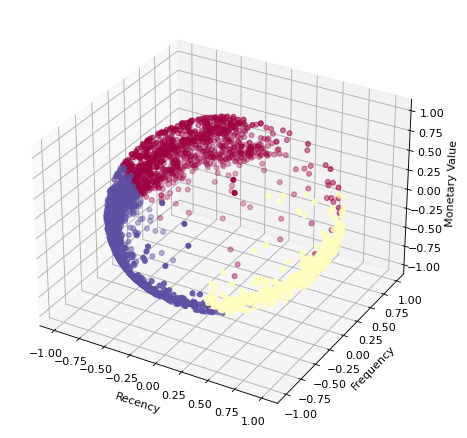

In [251]:
fig = plt.figure(figsize=(12,7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(norm.T[0],norm.T[1],norm.T[2],c=gmm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('Recency')
yLabel = ax.set_ylabel('Frequency')
zLabel = ax.set_zlabel('Monetary Value')

In [252]:
dfc = RFM
dfc['Clusters'] = list(gmm_labels)
customers = pd.DataFrame(dfc['Clusters'].value_counts()/len(dfc)).rename(columns={'Clusters':'Number of Customers'})

In [253]:
customers.T*len(dfc)

,2,1,0
Number of Customers,1995.0,1325.0,1019.0


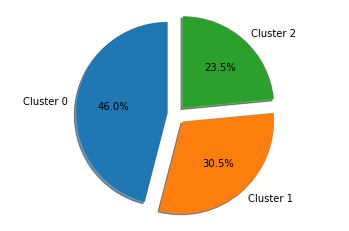

In [254]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Cluster 0', 'Cluster 1', 'Cluster 2';
sizes = customers['Number of Customers']
explode = (0.1,0.1,0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [255]:
plt.close()
means=pd.DataFrame(dfc.describe().loc['mean'])
#means.T.iloc[:,[0,1,6,8,9,11,12,16]].round(1)
means

,mean
Recency,92.518322
Frequency,91.708689
MonetaryValue,2053.793018
Clusters,1.224937


In [256]:
means.T.iloc[:,[0,1,2]].round(1)

,Recency,Frequency,MonetaryValue
mean,92.5,91.7,2053.8


In [257]:
df_gmm = pd.DataFrame({
'Recency': norm.T[0],
'Frequency': norm.T[1],
'MonetaryValue': norm.T[2],
'Clusters' : gmm_labels,
})
df_gmm

,Recency,Frequency,MonetaryValue,Clusters
0,0.268726,-0.045636,0.962135,0
1,-0.888395,0.387361,0.246386,0
2,-0.548722,-0.831210,-0.089414,2
3,-0.992885,-0.110445,-0.044516,2
4,0.985193,-0.147935,-0.086664,1
...,...,...,...,...
4334,0.976037,-0.187946,-0.109677,1
4335,0.899231,-0.376310,-0.223103,1
4336,-0.901331,-0.371569,-0.222574,2
4337,-0.291594,0.956541,0.001506,0


In [258]:
df_gmm.set_index('Clusters')
grouped=df_gmm.groupby(by='Clusters').mean().round(1)
df_gmm_mean = grouped.iloc[:,[0,1,2]]
df_gmm_mean

,Recency,Frequency,MonetaryValue
Clusters,,,
0,-0.7,0.5,0.2
1,0.9,-0.3,-0.2
2,-0.8,-0.4,-0.3


<AxesSubplot:xlabel='Clusters', ylabel='MonetaryValue'>

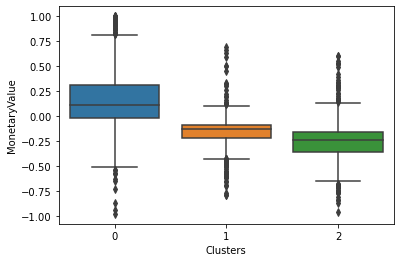

In [259]:
sns.boxplot(x='Clusters',y='MonetaryValue',data=df_gmm)

<AxesSubplot:xlabel='Clusters', ylabel='Frequency'>

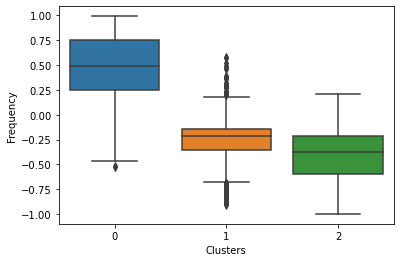

In [260]:
sns.boxplot(x='Clusters',y='Frequency',data=df_gmm)

<AxesSubplot:xlabel='Clusters', ylabel='Recency'>

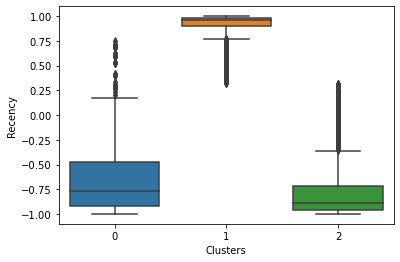

In [261]:
sns.boxplot(x='Clusters',y='Recency',data=df_gmm)

In [262]:

gmm_cluster

NameError: name 'gmm_cluster' is not defined

In [263]:
colors=["red","blue","green"]
# figure setting
plt.figure(figsize=(8,6))
for i in range (3):
    plt.scatter(df_gmm[df_gmm.Clusters==i].Frequency, df_gmm[df_gmm.Clusters==i].Recency, label=i, c=colors[i], alpha=0.5, s=40)
    plt.title("K-Means Clustering of Customer Data",size=20)
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.title('Scatter plot of Frequency vs. MonetaryValue ')
plt.legend()
plt.show()

NameError: name 'gmm_model' is not defined

In [264]:

def detect_outlier_Hampel(df):
    med=df.median()
    List=abs(df-med)
    cond=List.median()*4.5
    outliers_list=List[~(List<cond)]
    return outliers_list

print('Number of outliers in Frequency is :%d' %len(detect_outlier_Hampel(df_gmm.Frequency)))
print('Number of outliers in Recency is :%d'%len(detect_outlier_Hampel(df_gmm.Recency)))
print('Number of outliers in Monetary Value is :%d'%len(detect_outlier_Hampel(df_gmm.MonetaryValue)))
Outliers=detect_outlier_Hampel(df_gmm.Frequency)+detect_outlier_Hampel(df_gmm.Recency)+detect_outlier_Hampel(df_gmm.MonetaryValue)
print('Total number of outliers is :%d'%len(Outliers))




Number of outliers in Frequency is :151
Number of outliers in Recency is :1219
Number of outliers in Monetary Value is :280
Total number of outliers is :1634


In [265]:
import pickle
pickle.dump(Model_GMM,open('model_GMM_RFM.pkl','wb'))